In [1]:
import sagemaker
import boto3

sess = sagemaker.Session()
region = sess.boto_session.region_name
# sagemaker session bucket -> used for uploading data, models and logs
# sagemaker will automatically create this bucket if it not exists
default_bucket=None
if default_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    default_bucket = sess.default_bucket()

try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client('iam')
    role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']


print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {default_bucket}")
print(f"sagemaker session region: {region}")

sagemaker role arn: arn:aws:iam::808577411626:role/Slab01AIGCPracticerRole
sagemaker bucket: sagemaker-us-west-2-808577411626
sagemaker session region: us-west-2


In [2]:
code_tarname = 'acc_glm2_model'

!rm -rf {code_tarname}.tar.gz
!rm -rf {code_tarname}/.ipynb_checkpoints
!tar czvf {code_tarname}.tar.gz {code_tarname}/

# copy the deployment configs tar to a path (different from hf model artifacts)
s3_code_artifact = sess.upload_data(f"{code_tarname}.tar.gz", default_bucket, sagemaker.utils.name_from_base("tmp0625/v1"))
print(s3_code_artifact)

acc_glm2_model/
acc_glm2_model/model.py
acc_glm2_model/serving.properties
acc_glm2_model/requirements.txt
s3://sagemaker-us-west-2-808577411626/tmp0625/v1-2023-07-01-02-22-43-121/acc_glm2_model.tar.gz


In [3]:
from sagemaker.model import Model
from sagemaker import serializers, deserializers
from sagemaker import image_uris

In [4]:
# specify a inference container version, found at: 
# https://github.com/aws/deep-learning-containers/blob/master/available_images.md#large-model-inference-containers

inference_image_uri = f"763104351884.dkr.ecr.{region}.amazonaws.com/djl-inference:0.22.1-deepspeed0.9.2-cu118"

endpoint_name = sagemaker.utils.name_from_base(code_tarname.replace('_','-'))

In [5]:
model = Model(image_uri=inference_image_uri,
              model_data=s3_code_artifact, 
              role=role)

model.deploy(initial_instance_count = 1,
             instance_type = 'ml.g5.2xlarge', 
             endpoint_name = endpoint_name,
             container_startup_health_check_timeout = 900
            )

--------------!

## Predict

- Use the 'endpoint_name' variable defined above, or directly copy from SageMaker console
- ```endpoint_name = 'xxxxx'```

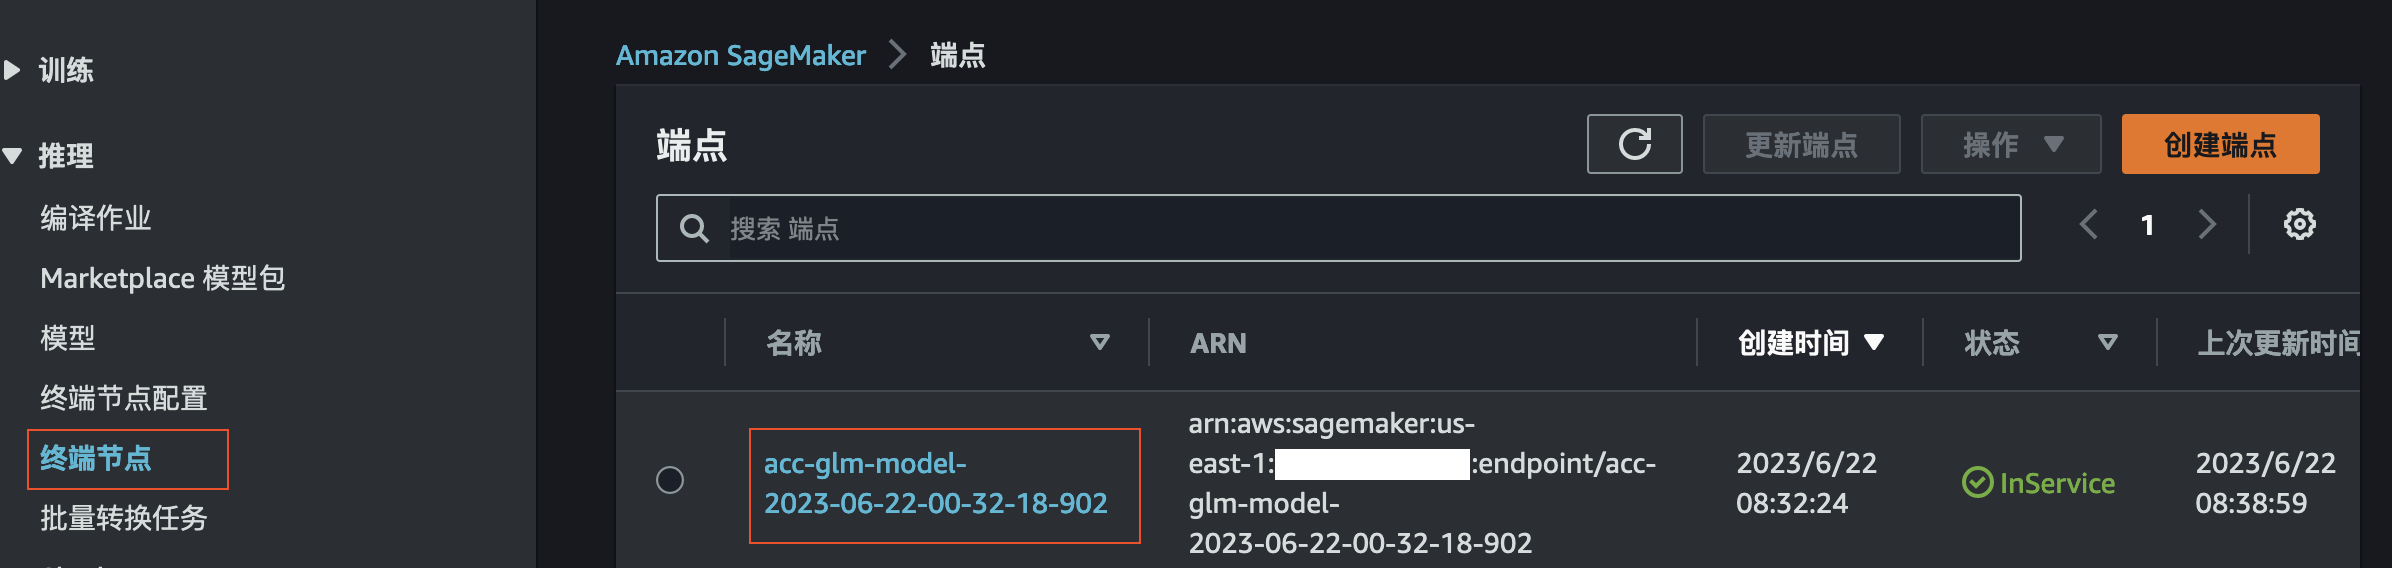

In [6]:
predictor = sagemaker.Predictor(
            endpoint_name=endpoint_name,
            sagemaker_session=sess,
            serializer=serializers.JSONSerializer(),
            deserializer=deserializers.JSONDeserializer(),
            )

parameters
> "max_length": 100, "top_p":0.45, "temperature":0.45

In [7]:
predictor.predict(
    {"inputs": "tuna sandwich nutritional content is ", 
     "parameters": {"max_length": 100, "top_p":0.45, "temperature":0.45},
     "history":[]
     }
)

{'response': 'A tuna sandwich typically consists of a slice of bread, spread with mayonnaise or other type of cheese, and may also include ingredients such as lettuce, tomato, and/or onion.\n\nHere is an approximate nutritional content for a medium-sized tuna sandwich:\n\n* Calories: 350-400\n* Total Fat:',
 'history': [['tuna sandwich nutritional content is ',
   'A tuna sandwich typically consists of a slice of bread, spread with mayonnaise or other type of cheese, and may also include ingredients such as lettuce, tomato, and/or onion.\n\nHere is an approximate nutritional content for a medium-sized tuna sandwich:\n\n* Calories: 350-400\n* Total Fat:']]}

In [8]:
resp = predictor.predict(
    {"inputs": "tuna sandwich nutritional content is ", 
     "parameters": {"max_length": 200, "top_p":0.45, "temperature":0.45},
     "history":[]
     }
)
print(resp['response'])

A tuna sandwich typically consists of a slice of bread, spread with mayonnaise or other type of cheese, and may also include ingredients such as lettuce, tomato, and/or onion.

Here is an approximate nutritional content for a medium-sized tuna sandwich:

* Calories: 350-400
* Total Fat: 23-26g
* Saturated Fat: 7-9g
* Cholesterol: 20mg
* Sodium: 70-80mg
* Total Carbohydrates: 30-35g
* Dietary Fiber: 1g
* Sugar: 10-15g
* Protein: 30-35g

Please note that this is just an approximate estimate and may vary


In [9]:
%%timeit -n3 -r1
predictor.predict(
    {"inputs": "tuna sandwich nutritional content is ", 
     "parameters": {"max_length": 200, "top_p":0.45, "temperature":0.45},
     "history":[]
     }
)

5.49 s ± 0 ns per loop (mean ± std. dev. of 1 run, 3 loops each)


In [10]:
%%timeit -n3 -r1
predictor.predict(
    {"inputs": "tuna sandwich nutritional content is ", 
     "parameters": {"max_length": 100, "top_p":0.45, "temperature":0.45},
     "history":[]
     }
)

2.39 s ± 0 ns per loop (mean ± std. dev. of 1 run, 3 loops each)


In [11]:
#### delete Inference endpoint after Step3 
predictor.delete_model()
predictor.delete_endpoint()